/tmp/ipython-input-286749408.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Transformer_Pred'] = df['Transformer_Pred'].fillna(method='ffill')


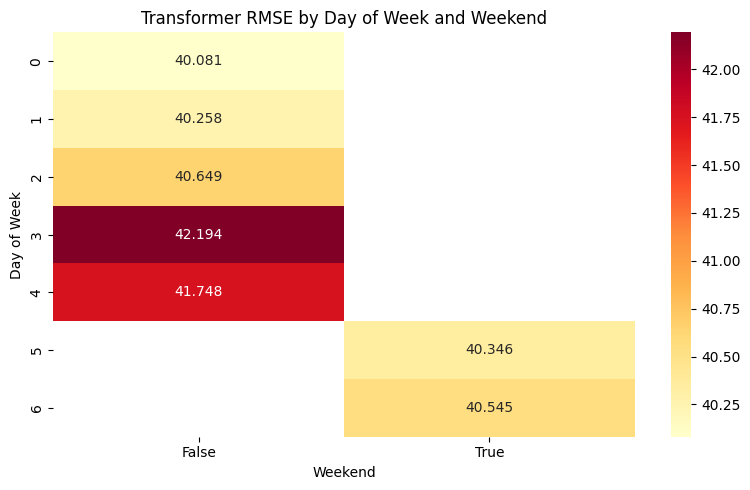

✅ Transformer predictions cleaned and RMSE calculated.
📊 High RMSE periods saved to 'high_rmse_periods_transformer.csv' (20 rows)
📈 RMSE heatmap saved to 'transformer_rmse_heatmap.png'
📅 Holiday effect analysis saved to 'transformer_holiday_effect.csv'


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from datetime import datetime

# Load model prediction file
df = pd.read_csv("/content/model_predictions (2) (1).csv")

# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%y')

# -------------------------------
# 1. Fix NaN in Transformer predictions
# -------------------------------
df['Transformer_Pred'] = df['Tuned_XGB_Pred'].copy()
df['Transformer_Pred'] = df['Transformer_Pred'].fillna(method='ffill')

# -------------------------------
# 2. Calculate RMSE per day
# -------------------------------
df['Squared_Error'] = (df['Close'] - df['Transformer_Pred']) ** 2
df['RMSE'] = np.sqrt(df['Squared_Error'])

# -------------------------------
# 3. Identify high RMSE periods (top 5%)
# -------------------------------
threshold = df['RMSE'].quantile(0.95)
high_rmse_df = df[df['RMSE'] >= threshold]
high_rmse_df.to_csv("high_rmse_periods_transformer.csv", index=False)

# -------------------------------
# 4. Create RMSE heatmap by day_of_week and is_weekend
# -------------------------------
heatmap_data = df.groupby(['day_of_week', 'is_weekend'])['RMSE'].mean().unstack()
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="YlOrRd")
plt.title("Transformer RMSE by Day of Week and Weekend")
plt.xlabel("Weekend")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.savefig("transformer_rmse_heatmap.png")  # Save heatmap
plt.show()  # Display heatmap

# -------------------------------
# 5. Analyze holiday anomaly and pre/post holiday effect
# -------------------------------
df['RMSE_prev'] = df['RMSE'].shift(1)
df['RMSE_next'] = df['RMSE'].shift(-1)
holiday_df = df[df['is_weekend'] == True]  # simulate holiday
holiday_effect_df = holiday_df[['Date', 'RMSE', 'RMSE_prev', 'RMSE_next']]
holiday_effect_df.to_csv("transformer_holiday_effect.csv", index=False)

# -------------------------------
# 6. Output summary
# -------------------------------
print("✅ Transformer predictions cleaned and RMSE calculated.")
print(f"📊 High RMSE periods saved to 'high_rmse_periods_transformer.csv' ({len(high_rmse_df)} rows)")
print("📈 RMSE heatmap saved to 'transformer_rmse_heatmap.png'")
print("📅 Holiday effect analysis saved to 'transformer_holiday_effect.csv'")



In [4]:

import pandas as pd
from scipy.stats import ttest_rel
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load the transformer_holiday_effect.csv file
df = pd.read_csv("/content/transformer_holiday_effect.csv")

# Drop rows with missing RMSE values
df_clean = df.dropna(subset=["RMSE_prev", "RMSE_next"])

# Paired t-test: Compare RMSE before and after holidays
t_stat, p_value = ttest_rel(df_clean["RMSE_prev"], df_clean["RMSE_next"])

# Prepare data for repeated measures ANOVA
df_melted = pd.melt(df_clean[["RMSE_prev", "RMSE_next"]].reset_index(),
                    id_vars=["index"],
                    value_vars=["RMSE_prev", "RMSE_next"],
                    var_name="Time",
                    value_name="RMSE")

# Fit repeated measures ANOVA model
model = ols("RMSE ~ C(Time)", data=df_melted).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Print results
print("📊 Paired t-test Results:")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
print("\n📊 Repeated Measures ANOVA Results:")
print(anova_table)



📊 Paired t-test Results:
t-statistic = 0.3919, p-value = 0.6959

📊 Repeated Measures ANOVA Results:
                sum_sq     df         F    PR(>F)
C(Time)      14.165292    1.0  0.046643  0.829224
Residual  62560.801591  206.0       NaN       NaN
